In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
!kaggle datasets download -d helviz/iris-data

! unzip "iris-data.zip"


Dataset URL: https://www.kaggle.com/datasets/helviz/iris-data
License(s): unknown
 99% 1.34G/1.35G [00:12<00:00, 205MB/s]
100% 1.35G/1.35G [00:12<00:00, 119MB/s]
Archive:  iris-data.zip
  inflating: Retinal fundus images for DR/1.train/1. No DR signs/10.jpg  
  inflating: Retinal fundus images for DR/1.train/1. No DR signs/100.jpg  
  inflating: Retinal fundus images for DR/1.train/1. No DR signs/101.jpg  
  inflating: Retinal fundus images for DR/1.train/1. No DR signs/103.jpg  
  inflating: Retinal fundus images for DR/1.train/1. No DR signs/104.jpg  
  inflating: Retinal fundus images for DR/1.train/1. No DR signs/107.jpg  
  inflating: Retinal fundus images for DR/1.train/1. No DR signs/109.jpg  
  inflating: Retinal fundus images for DR/1.train/1. No DR signs/110.jpg  
  inflating: Retinal fundus images for DR/1.train/1. No DR signs/111.jpg  
  inflating: Retinal fundus images for DR/1.train/1. No DR signs/112.jpg  
  inflating: Retinal fundus images for DR/1.train/1. No DR signs/

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile

In [7]:
# Allow truncated images to load
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Directories for dataset
data_dir = "//content/Retinal fundus images for DR/1.train"

# Image Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

# Data Augmentation & Preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

def safe_flow_from_directory(*args, **kwargs):
    while True:
        try:
            generator = datagen.flow_from_directory(*args, **kwargs)
            return generator
        except OSError:
            print("Skipping a corrupted image...")

train_generator = safe_flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = safe_flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_generator.class_indices)

# Define the Capsule Network Model
class ReinforcedCapsNet(keras.Model):
    def __init__(self, num_classes):
        super(ReinforcedCapsNet, self).__init__()
        self.conv1 = layers.Conv2D(64, (5, 5), activation='relu', padding='same')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.primary_caps = layers.Conv2D(256, (9, 9), strides=2, activation='relu')
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.primary_caps(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Initialize and Compile Model
model = ReinforcedCapsNet(num_classes)
model.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 3))
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train Model
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Evaluate Model
y_true, y_pred = [], []
for images, labels in val_generator:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= val_generator.samples:
        break

# Classification Report
class_labels = list(train_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Found 513 images belonging to 7 classes.
Found 125 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'reinforced_caps_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 304s 18s/step - accuracy: 0.2046 - loss: 1.9040 - val_accuracy: 0.3600 - val_loss: 1.9501
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 321s 19s/step - accuracy: 0.2999 - loss: 1.7982 - val_accuracy: 0.3600 - val_loss: 1.8202
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 298s 18s/step - accuracy: 0.4267 - loss: 1.5259 - val_accuracy: 0.3600 - val_loss: 1.5699
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 308s 18s/step - accuracy: 0.4799 - loss: 1.3134 - val_accuracy: 0.5680 - val_loss: 1.6378
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 298s 17s/step - accuracy: 0.5420 - loss: 1.2145 - val_accuracy: 0.5200 - val_loss: 1.3982
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 306s 18s/step - accuracy: 0.5764 - loss: 1.1363 - val_accuracy: 0.5840 - val_loss: 1.4116
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 299s 17s/step - accuracy: 0.6186 - loss: 1.0477 - val_accuracy: 0.5840 - val_loss: 1.4263
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 306s 18s/step - accuracy: 0.6468 - loss: 1.0331 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


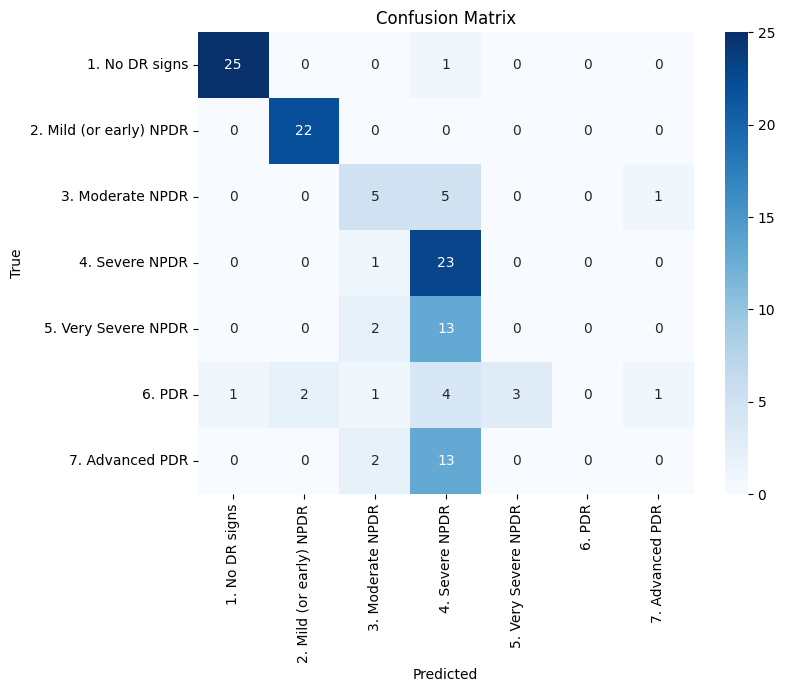

Accuracy: 0.6000
Precision: nan
Recall (Sensitivity): 0.4821
F1-Score: nan
Specificity: 0.8711


<ipython-input-8-ac90a53ee71f>:16: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)
<ipython-input-8-ac90a53ee71f>:18: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


In [8]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute Metrics
TN = np.diag(cm).sum() - cm.sum(axis=0)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
accuracy = np.trace(cm) / np.sum(cm)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall (Sensitivity): {np.mean(recall):.4f}")
print(f"F1-Score: {np.mean(f1_score):.4f}")
print(f"Specificity: {np.mean(specificity):.4f}")

In [ ]:
!pip install tensorflow
